# Molecular Dynamics Lite workflow
This notebook implements a simple molecular dynamics (MD) workflow to demonstrate [Parsl Python parallel scripting](https://parsl-project.org/) in a Jupyter notebook. This workflow first runs MD simulations in parallel on remote resources and then renders the frames of an animation visualizing the simulation according to the schematic below.

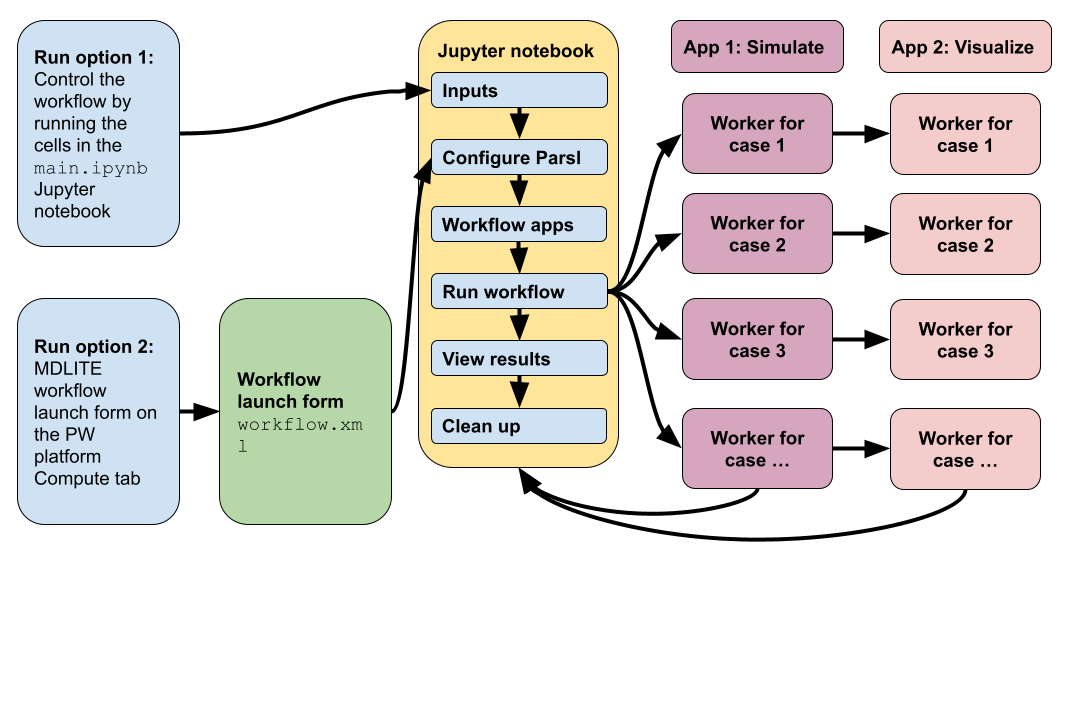

In [1]:
from IPython.display import Image
Image("images/mdlite-parameter-sweep.png")

## Step 1: Define workflow inputs
This PW workflow can be either launched from its form in the `Compute` tab or it can be run directly in this notebook.  If running directly from the notebook, the user needs to go through the extra step of defining the inputs of the workfow in the notebook.

In [20]:
import os
from os.path import exists

print('Define workflow inputs...')

# Start assuming workflow is launched from the form.
run_in_notebook=False

if (exists("./params.run")):
    print("Running from a PW form.")
    
else:
    print("Running from a notebook.")
    
    # Set flag for later
    run_in_notebook=True
    
    #TO DO: AUTOMATE THE PROCESS OF GRABING PW.CONF.
    
    # Manually set workflow inputs here (same as the
    # default values in workflow launch form)
    # params="npart;input;25:50:25|steps;input;3000:6000:3000|mass;input;0.01:0.02:0.01|trsnaps;input;5:10:5|"
    params="npart;input;25:75:25|steps;input;3000:9000:3000|mass;input;0.01:0.03:0.01|trsnaps;input;5:15:10|"
    
    print(params)
    
    # Write to params.run
    with open("params.run","w") as f:
        n_char_written = f.write(params+"\n")

Define workflow inputs...
Running from a notebook.
npart;input;25:75:25|steps;input;3000:9000:3000|mass;input;0.01:0.03:0.01|trsnaps;input;5:15:10|


## Step 2: Configure Parsl
The molecular dynamics software itself is a lightweight, precompiled executable written in C. The executable is distributed with this workflow in `./models/mdlite`, and along with input files, it is staged to the remote resources and does not need to be preinstalled.

The core visualization tool used here is a precompiled binary of [c-ray](https://github.com/vkoskiv/c-ray) distributed with this workflow in `./models/c-ray`. The executable is staged to remote resources and does not need to be preinstalled.

In addition to a Miniconda environment containing Parsl, the only other dependency of this workflow is ImageMagick's `convert` tool for image format conversion (`.ppm` to `.png`) and building animated `.gif` files from `.png` frames.

In [21]:
# Parsl essentials
import parsl
from parsl.app.app import python_app, bash_app
from parsl.data_provider.files import File

# PW essentials
from utils.path import Path
from parslpw import pwconfig,pwargs

# For embedding Design Explorer results in notebook
from IPython.display import display, HTML

# Checking inputs from the WORKFLOW FORM
if (not run_in_notebook):
    print(pwargs)

print("Configuring Parsl...")
parsl.load(pwconfig)
print("pwconfig loaded")

Configuring Parsl...
pwconfig loaded


## Step 3: Define Parsl workflow apps
These apps are decorated with Parsl's `@bash_app` and as such are executed in parallel on the compute resources that are defined in the PW configuration loaded above.  Functions that are **not** decorated are not executed in parallel on remote resources. The files that need to be staged to remote resources will be marked with Parsl's `File()` (or its PW extension, `Path()`) in the workflow.

In [4]:
print("Defining Parsl workflow apps...")

#===================================
# Molecular dynamics simulation app
#===================================
@bash_app
def md_run(stdout='md.run.stdout', stderr='md.run.stderr', inputs=[], outputs=[]):
    return '''
    %s/runMD.sh "%s" metric.out trj.out
    outdir=%s
    mkdir -p $outdir
    mv trj.out $outdir/
    mv metric.out $outdir/
    ''' % (inputs[1],inputs[0],outputs[0])

#===================================
# App to render frames for animation
#===================================
# All frames for a given simulation
# are rendered together.

# This app takes a very simple 
# approach to zero padding by adding 
# integers to 1000.
@bash_app
def md_vis_3(stdout='md.vis.stdout', stderr='md.vis.stderr', inputs=[], outputs=[]):
    return '''
    indir=%s
    outdir=%s
    mkdir -p $outdir
    for (( ff=0; ff<%s; ff++ ))
    do
        frame_num_padded=$((1000+$ff))
        %s/renderframe $indir/trj.out $outdir/f_$frame_num_padded.ppm $ff
    done
    ''' % (inputs[2],outputs[0],inputs[0],inputs[1])

Defining Parsl workflow apps...


## Step 4: Workflow
This cell executes the workflow itself.

In [5]:
print("Running workflow...")

#============================================================================
# SETUP PARAMETER SWEEP
#============================================================================
# Generate a case list from params.run (the ranges to parameters to sweep)
os.system("python ./models/mexdex/prepinputs.py params.run cases.list")

# Each line in cases.list is a unique combination of the parameters to sweep.
with open("cases.list","r") as f:
    cases_list = f.readlines()

#============================================================================
# SIMULATE
#============================================================================
# For each line in cases.list, run and visualize a molecular dynamics simulation
# These empty lists will store the futures of Parsl-parallelized apps.
# Use Path for staging because multiple files in ./models/mdlite are needed
# and mutliple files in ./results/case_*/md are sent back to the platform.
md_run_fut = []
for ii, case in enumerate(cases_list):        
    # Run simulation
    md_run_fut.append(md_run(
        inputs=[case,
            Path("./models/mdlite")],
        outputs=[Path("./results/case_"+str(ii)+"/md")]))
    
# Call results for all app futures to require
# execution to wait for all simulations to complete.
for run in md_run_fut:
    run.result()

#============================================================================
# VISUALIZE
#============================================================================
md_vis_fut = []
for ii, case in enumerate(cases_list):
    # Get number of frames to render for this case
    nframe = int(case.split(',')[4])
    
    #=========================================================
    # Render all frames for each case in one app.  This approach
    # reduces the number of SSH connections (e.g. rsync instances) 
    # compared to an app that only renders one frame at a time.
    md_vis_fut.append(md_vis_3(
        inputs=[nframe,
                Path("./models/c-ray"),
                Path("./results/case_"+str(ii)+"/md")],
        outputs=[Path("./results/case_"+str(ii)+"/vis")]))

for vis in md_vis_fut:
    vis.result()
    
# Compile frames into movies locally
for ii, case in enumerate(cases_list):
    os.system("cd ./results/case_"+str(ii)+"/vis; convert -delay 10 *.ppm mdlite.gif")

# Compile movies into Design Explorer results locally
os.system("./models/mexdex/postprocess.sh mdlite_dex.csv mdlite_dex.html ./")

Running workflow...


0

## Step 5: View results
This step is only necessary when running directly in a notebook. The outputs of this workflow are stored in the `results` folder and they can be interactively visualized with the Design Explorer by clicking on `mdlite_dex.html` which uses `mdlite_dex.csv` and the data in the `results` folder. The Design Explorer visualization is automatically embedded below.

In [17]:
# Modify width, height, and screen resolution to display as wanted
from IPython.display import IFrame
def designExplorer(url,height=500):
    return IFrame(url, width=1000, height=height)


# Makre sure path 'datafile=/pw/workflows/test_workflow/mdlite_dex.csv' is correct
designExplorer('/preview/DesignExplorer/index.html?datafile=/pw/workflows/test_workflow/mdlite_dex.csv&colorby=kinetic',height=600)

## Step 6: Clean up
This step is only necessary when running directly in a notebook. These intermediate and log files are removed to keep the workflow file structure clean if this workflow is pushed into the PW Market Place.  Please feel free to comment out these lines in order to inspect intermediate files as needed. The first two, `params.run` and `cases.list` are explicitly created by the workflow in Steps 1 and 4, respectively.  The other files are generated automatically for logging, keeping track of workers, or starting up workers. **Note that even the results are deleted!**

In [10]:
if (run_in_notebook):
    !rm -f params.run
    !rm -f cases.list
    !rm -rf runinfo
    !rm -rf __pycache__
    !rm -rf parsl-task.*
    !rm -rf *.pid
    !rm -rf *.started
    !rm -rf *.cancelled
    !rm -rf *.cogout
    !rm -rf lastid*
    !rm -rf launchcmd.*
    !rm -rf parsl-htex-worker.sh
    # Retain pw.conf if re-running this notebook on the 
    # same resource and there is no resource Off/On cycling.
    # (See README.md for more information.)
    # !rm -rf pw.conf*
    # Delete outputs
    !rm -rf ./results
    !rm -f mdlite_dex.*

# Step 6: Plots

### Pseudo Code

- Plots 2 graphs side by side: one is std vs. time, and the other is mean vs. time. 
    - Aim to show all cases on both of the graphs.

- To show all of std vs time and mean vs time 
-- Need a dataframe contains time and std of each case. Same as mean vs time 
-- To get dataframe of time and std, need to get a list of std, mean, and time for each case

- Might need to create dataframe variables for each cases here first to later be able to use it to graph all of it in the same graph.

- Loop through each case in results folder
    - Go through each time in each case
    -- Store in a time list: t_val_*, the * use to indicate the case number
        - Get root mean square of std and mean for x_pos, y_pos, and z_pos
            - Get std of each x_pos, y_pos, z_pos
            - Calculate the root mean square by using the formula:
              sqrt( std(x_pos)^2 + std(y_pos)^2 + std(z_pos)^2 )
            - Store in a rt_mean_sq_std_* list to later use it to combine with time list to create dataframe
              
            - Get mean of each x_pos, y_pos, z_pos
            - Calculate the root mean square by using the fomula:
              sqrt( mean(pos_x)^2 + mean(pos_y)^2 + mean(pos_z)^2 )
            - Store in a rt_mean_sq_mean_* list to later use it to combine with time list to create dataframe 
    - Put the time values and root mean square of std in a dataframe: combine t_val_* and rt_mean_sq_std_*. Name the dataframe as std_vs_time_*
    - Put the time values and root mean square of mean in a dataframe: combine t_val_* and rt_mean_sq_mean_*. Name the dataframe as mean_vs_time_*
    - Show the dataframe of root mean square of std vs time and root mean square of mean vs time for each case
    -- Store it in different case with different name such as case_0, case_1, case_2,...
- Plot each case on the same graph of std vs time and mean vs time, then lable cases by color code it.

In [39]:
# Import needed libraries
import pandas as pd
import numpy as np
import glob
import math 
import matplotlib.pyplot as plt

## Load data, clean data, and calculation

In [94]:
list_of_dirs = glob.glob("../test_workflow/results/case_*")
# print(list_of_dirs)

print("All cases")

cases = []
all_cases_time_val = []
all_cases_rt_mean_sq_std = []
all_cases_rt_mean_sq_mean = []

# Get all cases in the results folder
for i in list_of_dirs:
    # case_num = i
    # print("Case " + str(case_num))
    print("\n\nShow case info...")
    path = i + "/md/trj.out"
    print(path)
    case = i[i.index('case'):]
    print("Case:", case)
    # Might not need this
    # case_num = int(case[case.index('_')+1:])
    # print("Case number:", case_num)
    cases.append(case)
    # cases[case_num] = case
    
    print("Convert to data type...")
    data = pd.read_csv(path, sep=" ")
    print("Data shape",data.shape)
    
    # Add name to the columns
    data.columns=['time', 'var', 'x_pos', 'y_pos', 'z_pos', 'ig0', 'ig1', 'ig2', 'ig3', 'ig4', 'ig5']
    print("Data with name columns")
    print(data.head(2))
    
    # Get all time values of this case
    t_val = data['time'].unique()
    print("Time values of this case:", t_val)
    all_cases_time_val.append(t_val)
    # all_cases_time_val[case_num] = t_val
    
    # Count total data of each time value
    t_val_count = data.groupby('time')['x_pos','y_pos','z_pos'].count()
    # print("Total data of each time value in this case:")
    # print(t_val_count)
    
    one_case_rt_mean_sq_std = []
    one_case_rt_mean_sq_mean = []
    print("INITIALIZE:")
    print(one_case_rt_mean_sq_std)
    print(one_case_rt_mean_sq_mean)
    # Loop through the time values list for each time value
    for t in t_val:
        print("\nWith time value:", t)
        # Get x_pos, y_pos, z_pos for each time value
        each_time = data.loc[data['time'] == t, 'x_pos':'z_pos']
        # print(each_time)
        
        # Get mean and std of x_pos, y_pos, z_pos for each time
        # each_time.describe()

        print("std of all position at selected time:")
        all_pos_std = each_time.std()
        print(all_pos_std)
        
        print("means of all position at selected time:")
        all_pos_mean = each_time.mean()
        print(all_pos_mean)
        
        # Calculate root mean square of std and mean
        rt_mean_sq_std = math.sqrt((all_pos_std['x_pos'])**2 + (all_pos_std['y_pos'])**2 + (all_pos_std['z_pos'])**2)
        print("The root mean square std:", rt_mean_sq_std)
        one_case_rt_mean_sq_std.append(round(rt_mean_sq_std,6))

        rt_mean_sq_mean = math.sqrt((all_pos_mean['x_pos'])**2 + (all_pos_mean['y_pos'])**2 + (all_pos_mean['z_pos'])**2)
        print("The root mean square mean:", rt_mean_sq_mean)
        one_case_rt_mean_sq_mean.append(round(rt_mean_sq_mean,6))
        
    print("One case root mean square std all time:", one_case_rt_mean_sq_std)
    all_cases_rt_mean_sq_std.append(one_case_rt_mean_sq_std)
    print("One case root mean square mean all time:", one_case_rt_mean_sq_mean)
    all_cases_rt_mean_sq_mean.append(one_case_rt_mean_sq_mean)
    
# print("List of all cases:", cases)
print("Cases list length:", len(cases))
# print("List of all times in all cases:", all_cases_time_val)
print("All cases time list length:", len(all_cases_time_val))
# print("List of all root mean square std of all time in all cases:",all_cases_rt_mean_sq_std)
print("Root mean square std list length:", len(all_cases_rt_mean_sq_std))
# print("List of all root mean square mean of all time in all cases:",all_cases_rt_mean_sq_mean)
print("Root mean square mean list length:", len(all_cases_rt_mean_sq_mean))

All cases


Show case info...
../test_workflow/results/case_0/md/trj.out
Case: case_0
Convert to data type...
Data shape (124, 11)
Data with name columns
   time var     x_pos     y_pos     z_pos  ig0  ig1  ig2   ig3   ig4  ig5
0     0   s  0.315908  1.295474 -1.079809  0.1  1.0  0.2  0.05  50.0  0.1
1     0   s -1.079809 -0.934800  0.917601  0.1  1.0  0.2  0.05  50.0  0.1
Time values of this case: [0 1 2 3 4]
INITIALIZE:
[]
[]

With time value: 0
std of all position at selected time:
x_pos    1.115265
y_pos    1.280148
z_pos    1.198368
dtype: float64
means of all position at selected time:
x_pos    0.160944
y_pos   -0.017602
z_pos    0.064448
dtype: float64
The root mean square std: 2.0781439858952653
The root mean square mean: 0.1742591290286528

With time value: 1
std of all position at selected time:
x_pos    1.150478
y_pos    1.290167
z_pos    1.168607
dtype: float64
means of all position at selected time:
x_pos    0.084853
y_pos    0.046581
z_pos    0.074506
dtype: float64
The r

With time value: 7
std of all position at selected time:
x_pos    1.155472
y_pos    1.043432
z_pos    1.211890
dtype: float64
means of all position at selected time:
x_pos    0.278803
y_pos    0.396738
z_pos    0.243601
dtype: float64
The root mean square std: 1.97295311628901
The root mean square mean: 0.5426540118712327

With time value: 8
std of all position at selected time:
x_pos    1.159404
y_pos    1.055163
z_pos    1.216616
dtype: float64
means of all position at selected time:
x_pos    0.278803
y_pos    0.396738
z_pos    0.242757
dtype: float64
The root mean square std: 1.984374109259781
The root mean square mean: 0.5422759157275493

With time value: 9
std of all position at selected time:
x_pos    1.161807
y_pos    1.068370
z_pos    1.219452
dtype: float64
means of all position at selected time:
x_pos    0.278803
y_pos    0.396738
z_pos    0.242279
dtype: float64
The root mean square std: 1.9945608991543753
The root mean square mean: 0.5420619305880008

With time value: 10
st

x_pos    0.994257
y_pos    1.185063
z_pos    1.022532
dtype: float64
means of all position at selected time:
x_pos   -0.103476
y_pos    0.303526
z_pos   -0.123477
dtype: float64
The root mean square std: 1.8543174112977319
The root mean square mean: 0.3436309639451778

With time value: 1
std of all position at selected time:
x_pos    0.987294
y_pos    1.169695
z_pos    1.015009
dtype: float64
means of all position at selected time:
x_pos   -0.121331
y_pos    0.309376
z_pos   -0.141120
dtype: float64
The root mean square std: 1.8366218448898703
The root mean square mean: 0.3610393281286165

With time value: 2
std of all position at selected time:
x_pos    0.979360
y_pos    1.163723
z_pos    1.006781
dtype: float64
means of all position at selected time:
x_pos   -0.121331
y_pos    0.309376
z_pos   -0.140549
dtype: float64
The root mean square std: 1.8240076950139343
The root mean square mean: 0.360816567335864

With time value: 3
std of all position at selected time:
x_pos    0.968724
y_

Data shape (749, 11)
Data with name columns
   time var     x_pos     y_pos     z_pos  ig0  ig1  ig2   ig3   ig4  ig5
0     0   s -1.458927 -0.394093 -0.419925  0.1  1.0  0.2  0.05  50.0  0.1
1     0   s -0.419925 -0.191496  0.169615  0.1  1.0  0.2  0.05  50.0  0.1
Time values of this case: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
INITIALIZE:
[]
[]

With time value: 0
std of all position at selected time:
x_pos    1.176461
y_pos    1.087597
z_pos    1.192771
dtype: float64
means of all position at selected time:
x_pos   -0.009903
y_pos    0.198205
z_pos   -0.020945
dtype: float64
The root mean square std: 1.9974061458078674
The root mean square mean: 0.1995542037775917

With time value: 1
std of all position at selected time:
x_pos    1.171195
y_pos    1.091325
z_pos    1.179557
dtype: float64
means of all position at selected time:
x_pos   -0.039541
y_pos    0.231400
z_pos   -0.044816
dtype: float64
The root mean square std: 1.9884777280591615
The root mean square mean: 0.238993

std of all position at selected time:
x_pos    1.100896
y_pos    1.018278
z_pos    1.117947
dtype: float64
means of all position at selected time:
x_pos    0.169694
y_pos    0.212105
z_pos    0.159141
dtype: float64
The root mean square std: 1.8704727571985549
The root mean square mean: 0.3148183506065399

With time value: 10
std of all position at selected time:
x_pos    1.099867
y_pos    1.009260
z_pos    1.116316
dtype: float64
means of all position at selected time:
x_pos    0.169694
y_pos    0.212105
z_pos    0.159632
dtype: float64
The root mean square std: 1.863994351355874
The root mean square mean: 0.31506679592393694

With time value: 11
std of all position at selected time:
x_pos    1.097035
y_pos    0.999642
z_pos    1.112605
dtype: float64
means of all position at selected time:
x_pos    0.169694
y_pos    0.212105
z_pos    0.160338
dtype: float64
The root mean square std: 1.854901195839067
The root mean square mean: 0.31542514764193424

With time value: 12
std of all posit


With time value: 14
std of all position at selected time:
x_pos    1.005359
y_pos    1.223927
z_pos    1.066489
dtype: float64
means of all position at selected time:
x_pos    0.592270
y_pos   -0.278386
z_pos    0.565123
dtype: float64
The root mean square std: 1.909487977651384
The root mean square mean: 0.8646651811543434
One case root mean square std all time: [1.956015, 1.942841, 1.937941, 1.931373, 1.923616, 1.915807, 1.90992, 1.907367, 1.90734, 1.908121, 1.908993, 1.909917, 1.910529, 1.9104, 1.909488]
One case root mean square mean all time: [0.914589, 0.85647, 0.856983, 0.857695, 0.858588, 0.859617, 0.860712, 0.861789, 0.862769, 0.86359, 0.864219, 0.864643, 0.864858, 0.864865, 0.864665]


Show case info...
../test_workflow/results/case_22/md/trj.out
Case: case_22
Convert to data type...
Data shape (124, 11)
Data with name columns
   time var     x_pos     y_pos     z_pos  ig0  ig1  ig2   ig3   ig4  ig5
0     0   s  1.818082  0.682507  0.911712  0.1  1.0  0.2  0.05  50.0  0.1
1 

The root mean square mean: 0.22691375555859983

With time value: 10
std of all position at selected time:
x_pos    1.138008
y_pos    1.007191
z_pos    1.147970
dtype: float64
means of all position at selected time:
x_pos   -0.128258
y_pos    0.131144
z_pos   -0.134803
dtype: float64
The root mean square std: 1.9045550242442892
The root mean square mean: 0.2276419035632455

With time value: 11
std of all position at selected time:
x_pos    1.135479
y_pos    1.006181
z_pos    1.147459
dtype: float64
means of all position at selected time:
x_pos   -0.128258
y_pos    0.131144
z_pos   -0.136299
dtype: float64
The root mean square std: 1.9022027158825832
The root mean square mean: 0.22853059471739445

With time value: 12
std of all position at selected time:
x_pos    1.132664
y_pos    1.005393
z_pos    1.146944
dtype: float64
means of all position at selected time:
x_pos   -0.128258
y_pos    0.131144
z_pos   -0.138099
dtype: float64
The root mean square std: 1.8997955613159778
The root mean 

std of all position at selected time:
x_pos    1.069795
y_pos    1.165847
z_pos    1.085997
dtype: float64
means of all position at selected time:
x_pos    0.146294
y_pos    0.041731
z_pos    0.137375
dtype: float64
The root mean square std: 1.9191272847711334
The root mean square mean: 0.2049762254043077

With time value: 8
std of all position at selected time:
x_pos    1.074422
y_pos    1.166030
z_pos    1.094494
dtype: float64
means of all position at selected time:
x_pos    0.146294
y_pos    0.041731
z_pos    0.134779
dtype: float64
The root mean square std: 1.9266361392714983
The root mean square mean: 0.2032459654736476

With time value: 9
std of all position at selected time:
x_pos    1.080404
y_pos    1.167564
z_pos    1.104469
dtype: float64
means of all position at selected time:
x_pos    0.146294
y_pos    0.041731
z_pos    0.131791
dtype: float64
The root mean square std: 1.9365762073547734
The root mean square mean: 0.20127680865205008

With time value: 10
std of all positi

The root mean square mean: 0.315367309213013

With time value: 3
std of all position at selected time:
x_pos    1.177609
y_pos    1.104758
z_pos    1.185631
dtype: float64
means of all position at selected time:
x_pos   -0.209469
y_pos    0.094049
z_pos   -0.215452
dtype: float64
The root mean square std: 2.0032405813767338
The root mean square mean: 0.314868106373214

With time value: 4
std of all position at selected time:
x_pos    1.191077
y_pos    1.111796
z_pos    1.200416
dtype: float64
means of all position at selected time:
x_pos   -0.209469
y_pos    0.094048
z_pos   -0.216746
dtype: float64
The root mean square std: 2.0237968808662283
The root mean square mean: 0.3157553244955194

With time value: 5
std of all position at selected time:
x_pos    1.211158
y_pos    1.129015
z_pos    1.220270
dtype: float64
means of all position at selected time:
x_pos   -0.209469
y_pos    0.094048
z_pos   -0.216675
dtype: float64
The root mean square std: 2.056851312389093
The root mean square m

   time var     x_pos     y_pos     z_pos  ig0  ig1  ig2   ig3   ig4  ig5
0     0   s -0.669547 -1.178308  1.966564  0.1  1.0  0.2  0.05  50.0  0.1
1     0   s  1.966564  1.201841  0.449042  0.1  1.0  0.2  0.05  50.0  0.1
Time values of this case: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
INITIALIZE:
[]
[]

With time value: 0
std of all position at selected time:
x_pos    1.122676
y_pos    1.085747
z_pos    1.146045
dtype: float64
means of all position at selected time:
x_pos    0.128743
y_pos   -0.269150
z_pos    0.110764
dtype: float64
The root mean square std: 1.9371799554665226
The root mean square mean: 0.3182532016963583

With time value: 1
std of all position at selected time:
x_pos    1.123701
y_pos    1.080449
z_pos    1.130732
dtype: float64
means of all position at selected time:
x_pos    0.103904
y_pos   -0.249785
z_pos    0.099897
dtype: float64
The root mean square std: 1.9257799037109222
The root mean square mean: 0.28838863137447357

With time value: 2
std of all p

std of all position at selected time:
x_pos    1.120920
y_pos    1.108197
z_pos    1.162388
dtype: float64
means of all position at selected time:
x_pos   -0.249143
y_pos   -0.150368
z_pos   -0.284256
dtype: float64
The root mean square std: 1.9584965594201054
The root mean square mean: 0.4067975726428388

With time value: 2
std of all position at selected time:
x_pos    1.111098
y_pos    1.103530
z_pos    1.156857
dtype: float64
means of all position at selected time:
x_pos   -0.249143
y_pos   -0.150368
z_pos   -0.289972
dtype: float64
The root mean square std: 1.9469555204527915
The root mean square mean: 0.4108122736052856

With time value: 3
std of all position at selected time:
x_pos    1.117372
y_pos    1.101558
z_pos    1.160760
dtype: float64
means of all position at selected time:
x_pos   -0.249143
y_pos   -0.150368
z_pos   -0.286732
dtype: float64
The root mean square std: 1.9517462164107298
The root mean square mean: 0.4085314754284962

With time value: 4
std of all position

The root mean square std: 1.782269073902713
The root mean square mean: 0.8655496374925751

With time value: 14
std of all position at selected time:
x_pos    0.873994
y_pos    1.260439
z_pos    0.911004
dtype: float64
means of all position at selected time:
x_pos   -0.590232
y_pos    0.128272
z_pos   -0.622076
dtype: float64
The root mean square std: 1.7839565025433937
The root mean square mean: 0.8670677967905956
One case root mean square std all time: [1.806666, 1.775888, 1.772586, 1.774093, 1.774273, 1.770427, 1.767256, 1.768488, 1.771575, 1.77309, 1.772767, 1.774434, 1.778517, 1.782269, 1.783957]
One case root mean square mean all time: [0.829437, 0.855018, 0.854994, 0.854636, 0.854297, 0.854179, 0.854401, 0.85528, 0.856927, 0.85908, 0.860965, 0.862501, 0.864024, 0.86555, 0.867068]


Show case info...
../test_workflow/results/case_40/md/trj.out
Case: case_40
Convert to data type...
Data shape (124, 11)
Data with name columns
   time var     x_pos     y_pos     z_pos  ig0  ig1  ig2 

With time value: 1
std of all position at selected time:
x_pos    1.088017
y_pos    1.128162
z_pos    1.102010
dtype: float64
means of all position at selected time:
x_pos    0.018277
y_pos   -0.092135
z_pos    0.009964
dtype: float64
The root mean square std: 1.9159737630474667
The root mean square mean: 0.09445700666173996

With time value: 2
std of all position at selected time:
x_pos    1.079592
y_pos    1.122614
z_pos    1.095462
dtype: float64
means of all position at selected time:
x_pos    0.018277
y_pos   -0.092135
z_pos    0.008750
dtype: float64
The root mean square std: 1.9041587388937034
The root mean square mean: 0.09433668257027909

With time value: 3
std of all position at selected time:
x_pos    1.071064
y_pos    1.118384
z_pos    1.090476
dtype: float64
means of all position at selected time:
x_pos    0.018277
y_pos   -0.092135
z_pos    0.006268
dtype: float64
The root mean square std: 1.8939638632882434
The root mean square mean: 0.09413898017349887

With time value:


With time value: 4
std of all position at selected time:
x_pos    1.189701
y_pos    1.131421
z_pos    1.191590
dtype: float64
means of all position at selected time:
x_pos   -0.000241
y_pos   -0.048496
z_pos   -0.001375
dtype: float64
The root mean square std: 2.0286423061284014
The root mean square mean: 0.04851589993177173
One case root mean square std all time: [2.090975, 2.067504, 2.045542, 2.034414, 2.028642]
One case root mean square mean all time: [0.041655, 0.049942, 0.049463, 0.048751, 0.048516]


Show case info...
../test_workflow/results/case_49/md/trj.out
Case: case_49
Convert to data type...
Data shape (1124, 11)
Data with name columns
   time var     x_pos     y_pos     z_pos  ig0  ig1  ig2   ig3   ig4  ig5
0     0   s  1.726661  1.461088  1.272572  0.1  1.0  0.2  0.05  50.0  0.1
1     0   s  1.272572 -1.161541 -1.346436  0.1  1.0  0.2  0.05  50.0  0.1
Time values of this case: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
INITIALIZE:
[]
[]

With time value: 0
std of al

std of all position at selected time:
x_pos    1.079744
y_pos    1.056382
z_pos    1.081591
dtype: float64
means of all position at selected time:
x_pos   -0.054391
y_pos   -0.122193
z_pos   -0.055424
dtype: float64
The root mean square std: 1.8578561046521045
The root mean square mean: 0.14478023535566575

With time value: 8
std of all position at selected time:
x_pos    1.080138
y_pos    1.061573
z_pos    1.083153
dtype: float64
means of all position at selected time:
x_pos   -0.054391
y_pos   -0.122193
z_pos   -0.056102
dtype: float64
The root mean square std: 1.8619494990972318
The root mean square mean: 0.1450411102180344

With time value: 9
std of all position at selected time:
x_pos    1.086707
y_pos    1.065617
z_pos    1.090655
dtype: float64
means of all position at selected time:
x_pos   -0.054391
y_pos   -0.122193
z_pos   -0.056672
dtype: float64
The root mean square std: 1.8724316700094357
The root mean square mean: 0.14526280603710165

With time value: 10
std of all posit

## Plot

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


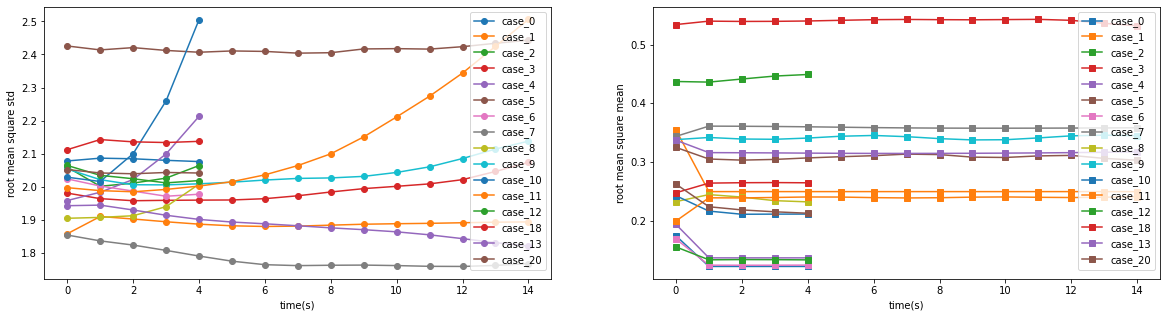

In [108]:
# # Plot side by side std vs. time and mean vs. time
# fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
# # ax0.plot(plot_data_std_0, 'r')
# ax0.plot(t_val_0,rt_mean_sq_std_0,'-ro')
# # ax0.plot(t_val_0,rt_mean_sq_mean_0,'-go')
# ax0.set_xlabel('time')
# ax0.set_ylabel('root mean square std')
# ax0.legend(['case_0'])

# ax1.plot(t_val_0,rt_mean_sq_mean_0,'-gs')
# ax1.set_xlabel('time')
# ax1.set_ylabel('root mean square mean')
# ax1.legend(['case_0'])

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))

for c in range(len(cases)):
    print(c)
    # ax0.plot(plot_data_std_0, 'r')
    ax0.plot(all_cases_time_val[c],all_cases_rt_mean_sq_std[c],'-o')
    # ax0.plot(t_val_0,rt_mean_sq_mean_0,'-go')
    ax0.set_xlabel('time(s)')
    ax0.set_ylabel('root mean square std')
    # ax0.legend([cases[r]])

    ax1.plot(all_cases_time_val[c],all_cases_rt_mean_sq_mean[c],'-s')
    ax1.set_xlabel('time(s)')
    ax1.set_ylabel('root mean square mean')
    # ax1.legend([cases[r]])
    
ax0.legend(cases)
ax1.legend(cases)

In [64]:
# Go through each cases

for index, value in enumerate(cases):
    print("Index:", index)
    print("Value:", value)

Index: 0
Vale: 0
Index: 1
Vale: 1
Index: 2
Vale: 2
Index: 3
Vale: 3
Index: 4
Vale: 4
Index: 5
Vale: 5
Index: 6
Vale: 6
Index: 7
Vale: 7
Index: 8
Vale: 8
Index: 9
Vale: 9
Index: 10
Vale: 10
Index: 11
Vale: 11
Index: 12
Vale: 12
Index: 13
Vale: 18
Index: 14
Vale: 13
Index: 15
Vale: 20
Index: 16
Vale: 21
Index: 17
Vale: 19
Index: 18
Vale: 22
Index: 19
Vale: 23
Index: 20
Vale: 24
Index: 21
Vale: 25
Index: 22
Vale: 14
Index: 23
Vale: 26
Index: 24
Vale: 15
Index: 25
Vale: 27
Index: 26
Vale: 31
Index: 27
Vale: 28
Index: 28
Vale: 30
Index: 29
Vale: 17
Index: 30
Vale: 16
Index: 31
Vale: 29
Index: 32
Vale: 32
Index: 33
Vale: 33
Index: 34
Vale: 36
Index: 35
Vale: 37
Index: 36
Vale: 38
Index: 37
Vale: 39
Index: 38
Vale: 42
Index: 39
Vale: 41
Index: 40
Vale: 40
Index: 41
Vale: 43
Index: 42
Vale: 44
Index: 43
Vale: 34
Index: 44
Vale: 45
Index: 45
Vale: 46
Index: 46
Vale: 35
Index: 47
Vale: 48
Index: 48
Vale: 49
Index: 49
Vale: 47
Index: 50
Vale: 51
Index: 51
Vale: 52
Index: 52
Vale: 50
Index: 53
Val

## Load data

In [43]:
# Just testing with one case right now
# need to make it work for all cases
data = pd.read_csv("../test_workflow/results/case_0/md/trj.out", sep=" ")
# print(data)
print(data.shape)

# Add name to the columns
data.columns=['time', 'var', 'x_pos', 'y_pos', 'z_pos', 'ig0', 'ig1', 'ig2', 'ig3', 'ig4', 'ig5']
print(data)

(124, 11)
     time var     x_pos     y_pos     z_pos  ig0  ig1  ig2   ig3   ig4  ig5
0       0   s  0.315908  1.295474 -1.079809  0.1  1.0  0.2  0.05  50.0  0.1
1       0   s -1.079809 -0.934800  0.917601  0.1  1.0  0.2  0.05  50.0  0.1
2       0   s  0.917601 -0.156247 -1.884792  0.1  1.0  0.2  0.05  50.0  0.1
3       0   s -1.884792 -0.534174  1.467972  0.1  1.0  0.2  0.05  50.0  0.1
4       0   s  1.467972  1.740939 -0.931221  0.1  1.0  0.2  0.05  50.0  0.1
..    ...  ..       ...       ...       ...  ...  ...  ...   ...   ...  ...
119     4   s -0.932175  0.688456 -0.568277  0.1  1.0  0.2  0.05  50.0  0.1
120     4   s -0.568277  1.875424 -0.008067  0.1  1.0  0.2  0.05  50.0  0.1
121     4   s -0.008067  0.413803 -1.143899  0.1  1.0  0.2  0.05  50.0  0.1
122     4   s -1.143899 -0.837616 -0.390179  0.1  1.0  0.2  0.05  50.0  0.1
123     4   s -0.390179 -1.730220 -2.000000  0.1  1.0  0.2  0.05  50.0  0.1

[124 rows x 11 columns]


In [44]:
# Get all time values
t_val_0 = data['time'].unique()
print(t_val_0)

# Count total data of each time values
t_val_0_count = data.groupby('time')['x_pos','y_pos','z_pos'].count()
print(t_val_0_count)

[0 1 2 3 4]
      x_pos  y_pos  z_pos
time                     
0        24     24     24
1        25     25     25
2        25     25     25
3        25     25     25
4        25     25     25


In [45]:
rt_mean_sq_std_0 = []
rt_mean_sq_mean_0 = []
# Loop through the time values list for each time value
for t in t_val_0:
    print("With time value:", t)
    # Get x_pos, y_pos, z_pos for each time value
    each_time = data.loc[data['time'] == t, 'x_pos':'z_pos']
    # print(each_time)
    
    # Get mean and std of x_pos, y_pos, z_pos for each time
    # each_time.describe()
    
    print("std of all position at selected time")
    all_pos_std = each_time.std()
    print(all_pos_std)

    print("means of all position at selected time")
    all_pos_mean = each_time.mean()
    print(all_pos_mean)
    
    # Calculate root mean square of std and mean
    rt_mean_sq_std = math.sqrt((all_pos_std['x_pos'])**2 + (all_pos_std['y_pos'])**2 + (all_pos_std['z_pos'])**2)
    print("The root mean square std:", rt_mean_sq_std)
    rt_mean_sq_std_0.append(round(rt_mean_sq_std,6))

    rt_mean_sq_mean = math.sqrt((all_pos_mean['x_pos'])**2 + (all_pos_mean['y_pos'])**2 + (all_pos_mean['z_pos'])**2)
    print("The root mean square mean:", rt_mean_sq_mean)
    rt_mean_sq_mean_0.append(round(rt_mean_sq_mean,6))
    
print("The list of root mean square std list of case_0:", rt_mean_sq_std_0)
print("The list of root mean square mean list of case_0:", rt_mean_sq_mean_0)

With time value: 0
std of all position at selected time
x_pos    1.115265
y_pos    1.280148
z_pos    1.198368
dtype: float64
means of all position at selected time
x_pos    0.160944
y_pos   -0.017602
z_pos    0.064448
dtype: float64
The root mean square std: 2.0781439858952653
The root mean square mean: 0.1742591290286528
With time value: 1
std of all position at selected time
x_pos    1.150478
y_pos    1.290167
z_pos    1.168607
dtype: float64
means of all position at selected time
x_pos    0.084853
y_pos    0.046581
z_pos    0.074506
dtype: float64
The root mean square std: 2.0865693744047773
The root mean square mean: 0.12215153865725309
With time value: 2
std of all position at selected time
x_pos    1.149448
y_pos    1.289015
z_pos    1.167592
dtype: float64
means of all position at selected time
x_pos    0.084853
y_pos    0.046581
z_pos    0.074506
dtype: float64
The root mean square std: 2.0847209744128854
The root mean square mean: 0.1221514559662324
With time value: 3
std of a

In [46]:
# Put together time and std and mean list into dataframe for plotting
# No need this step
plot_data_std_0 = pd.DataFrame(list(zip(t_val_0, rt_mean_sq_std_0)),columns =['time', 'rt_mean_sq_std'], index=None)
print("Dataframe std vs. time:")
print(plot_data_std_0)

plot_data_mean_0 = pd.DataFrame(list(zip(t_val_0, rt_mean_sq_mean_0)),columns =['time', 'rt_mean_sq_mean'])
print("Dataframe mean vs. time:")
print(plot_data_mean_0)


Dataframe std vs. time:
   time  rt_mean_sq_std
0     0        2.078144
1     1        2.086569
2     2        2.084721
3     3        2.080059
4     4        2.076310
Dataframe mean vs. time:
   time  rt_mean_sq_mean
0     0         0.174259
1     1         0.122152
2     2         0.122151
3     3         0.122151
4     4         0.122151


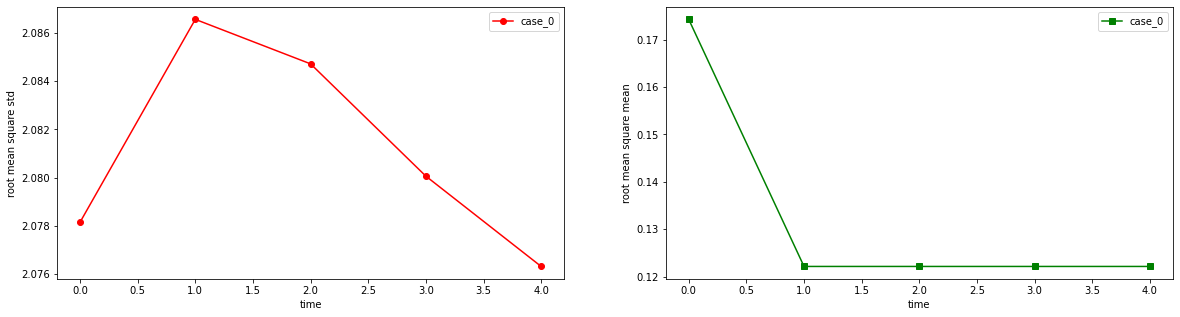

In [60]:
# Plot side by side std vs. time and mean vs. time
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
# ax0.plot(plot_data_std_0, 'r')
ax0.plot(t_val_0,rt_mean_sq_std_0,'-ro')
# ax0.plot(t_val_0,rt_mean_sq_mean_0,'-go')
ax0.set_xlabel('time')
ax0.set_ylabel('root mean square std')
ax0.legend(['case_0'])

ax1.plot(t_val_0,rt_mean_sq_mean_0,'-gs')
ax1.set_xlabel('time')
ax1.set_ylabel('root mean square mean')
ax1.legend(['case_0'])

In [48]:
# Get x_pos, y_pos, z_pos for each time value
each_time = data.loc[data['time'] == 0, 'x_pos':'z_pos']
print(each_time)

# Get mean and std of x_pos, y_pos, z_pos for each time
each_time.describe()

print("std of all position at selected time")
all_pos_std = each_time.std()
print(all_pos_std)

print("means of all position at selected time")
all_pos_mean = each_time.mean()
print(all_pos_mean)

print(type(all_pos_mean['y_pos']))

       x_pos     y_pos     z_pos
0   0.315908  1.295474 -1.079809
1  -1.079809 -0.934800  0.917601
2   0.917601 -0.156247 -1.884792
3  -1.884792 -0.534174  1.467972
4   1.467972  1.740939 -0.931221
5  -0.931221  0.697209  1.034861
6   1.034861  1.626006  0.830496
7   0.830496  0.433319 -1.247371
8  -1.247371 -0.766301  0.719423
9   0.719423  1.254149  0.790187
10  0.790187 -1.210420  1.568260
11  1.568260 -1.932731  1.623569
12  1.623569 -0.670458 -0.446041
13 -0.446041  1.790827  1.863894
14  1.863894 -1.847705  0.662159
15  0.662159 -1.205449 -1.039934
16 -1.039934 -1.086712 -0.030054
17 -0.030054 -1.120618  1.767667
18  1.767667  1.173745 -0.872912
19 -0.872912  1.232248 -0.571650
20 -0.571650  1.877759 -0.008067
21 -0.008067  0.413803 -1.197316
22 -1.197316 -0.762100 -0.390179
23 -0.390179 -1.730220 -2.000000
std of all position at selected time
x_pos    1.115265
y_pos    1.280148
z_pos    1.198368
dtype: float64
means of all position at selected time
x_pos    0.160944
y_pos   -0.0

In [49]:
# Calculate root mean square of std and mean
rt_mean_sq_std = math.sqrt((all_pos_std['x_pos'])**2 + (all_pos_std['y_pos'])**2 + (all_pos_std['z_pos'])**2)
print(rt_mean_sq_std)

rt_mean_sq_mean = math.sqrt((all_pos_mean['x_pos'])**2 + (all_pos_mean['y_pos'])**2 + (all_pos_mean['z_pos'])**2)
print(rt_mean_sq_mean)

2.0781439858952653
0.1742591290286528
